In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scipy
import lmfit
import emcee
#import pymc3
import pystan
import iminuit
from iminuit.util import describe, make_func_code

from keras.layers import Dense, Activation
from keras.models import Sequential

from multiprocessing import Pool
from chainconsumer import ChainConsumer

sns.set(context='talk', style='white')
%config InlineBackend.figure_format = 'retina'

np.random.seed(32)

This example was taken from the `emcee` documentation.

To avoid correlation between parameters in this case, one would need to shift the x-axis by the mean value, but I will ommit that in here for simplicity.

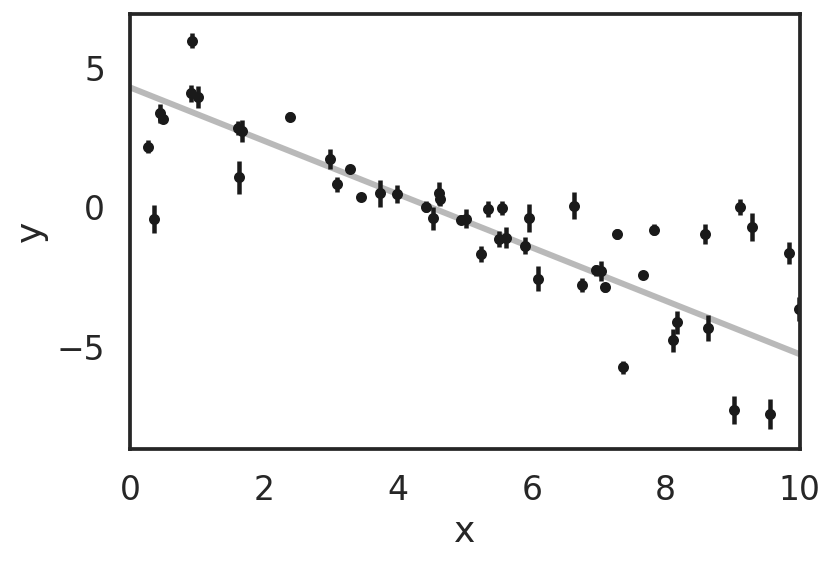

In [3]:
# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## scipy - minimize

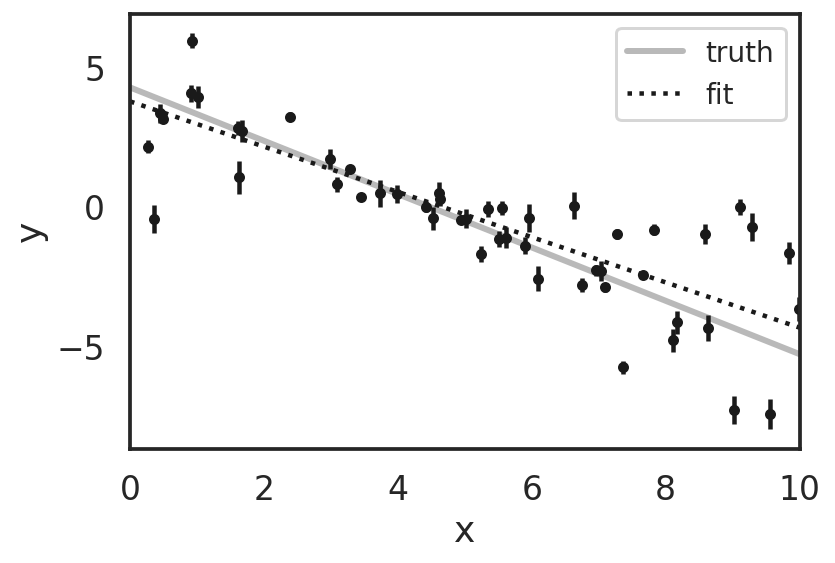

m = -0.8139 (m_true = -0.9594)
b = 3.792 (b_true = 4.294)


In [16]:
def log_likelihood(theta, x, y, yerr):
    m, b = theta
    model = m*x + b
    sigma2 = yerr**2
    return np.sum((y - model)**2 / sigma2)

p0 = np.array([m_true, b_true]) + 0.1 * np.random.randn(2)
results = scipy.optimize.minimize(log_likelihood, p0, args=(x, y, yerr))

m_pred, b_pred = results.x

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":k", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f'm = {m_pred:.4f} (m_true = {m_true})')
print(f'b = {b_pred:.3f} (b_true = {b_true})')

## scipy - curve_fit

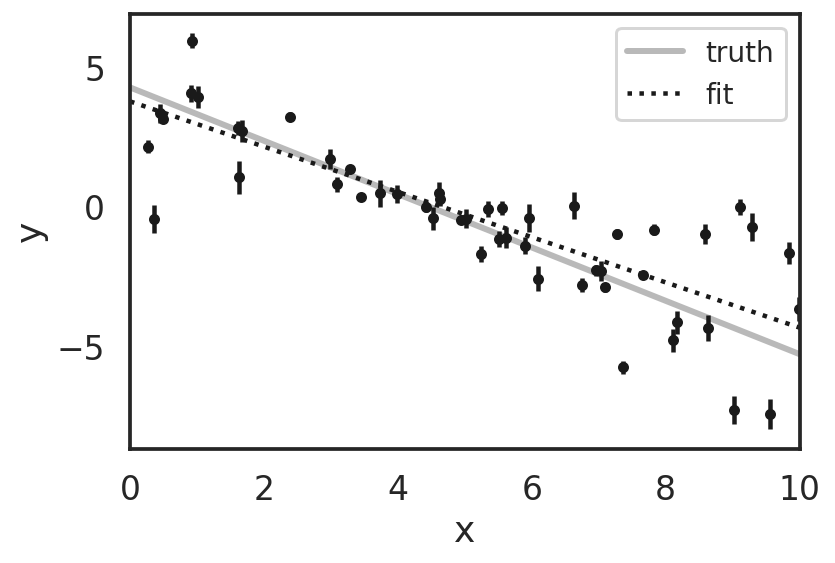

m = -0.8139 +/- 0.0647 (m_true = -0.9594)
b = 3.792 +/- 0.344 (b_true = 4.294)


In [17]:
def function(x, m, b):
    model = m*x + b
    return model

p0 = np.array([m_true, b_true]) + 0.1 * np.random.randn(2)
pfit, pcov = scipy.optimize.curve_fit(function, x, y, p0=p0, sigma=yerr)

m_pred, b_pred = pfit
m_std, b_std = np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1])

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":k", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f'm = {m_pred:.4f} +/- {m_std:.4f} (m_true = {m_true})')
print(f'b = {b_pred:.3f} +/- {b_std:.3f} (b_true = {b_true})')

## scipy - leastsq

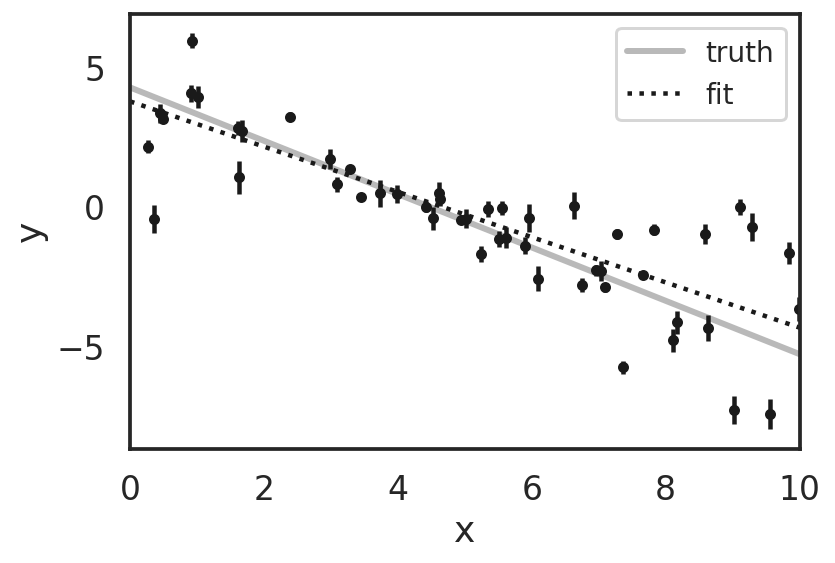

m = -0.8139 +/- 0.0127 (m_true = -0.9594)
b = 3.792 +/- 0.068 (b_true = 4.294)


In [18]:
def residual_function(theta, x, y, yerr):
    m, b = theta
    model = m*x + b
    return (model - y)/yerr

p0 = np.array([m_true, b_true]) + 0.1 * np.random.randn(2)
pfit, pcov, infodict, errmsg, success = scipy.optimize.leastsq(residual_function, p0, 
                                                               args=(x, y, yerr), 
                                                               full_output=1)

m_pred, b_pred = pfit
try:
    m_std, b_std = np.sqrt(pcov[0, 0]), np.sqrt(pcov[1, 1])
except:
    m_std = b_std = np.inf

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":k", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f'm = {m_pred:.4f} +/- {m_std:.4f} (m_true = {m_true})')
print(f'b = {b_pred:.3f} +/- {b_std:.3f} (b_true = {b_true})')

## lmfit

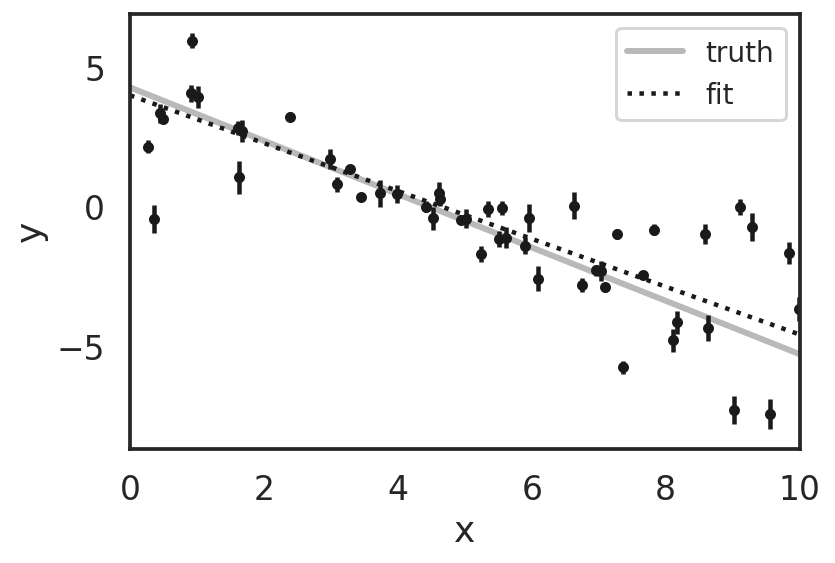

m = -0.8605 +/- inf (m_true = -0.9594)
b = 4.010 +/- inf (b_true = 4.294)


In [19]:
def residual_function(params, x, y, yerr):
    m, b = params['m'].value, params['b'].value
    model = m*x + b
    return ((model - y)/yerr)**2

p0 = np.array([m_true, b_true]) + 0.1 * np.random.randn(2)
params = lmfit.Parameters()
params.add('m', value=p0[0])
params.add('b', value=p0[1])
results = lmfit.minimizer.minimize(residual_function, params, args=(x, y, yerr)
                                   , method='lbfgsb')

m_pred, b_pred = results.params['m'].value, results.params['b'].value
m_std, b_std = results.params['m'].stderr, results.params['b'].stderr
if m_std is None and b_std is None:
    m_std = b_std = np.inf

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":k", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f'm = {m_pred:.4f} +/- {m_std:.4f} (m_true = {m_true})')
print(f'b = {b_pred:.3f} +/- {b_std:.3f} (b_true = {b_true})')

## iminuit

/home/tomas/anaconda3/envs/pisco/lib/python3.6/site-packages/ipykernel_launcher.py:11: InitialParamWarning: Parameter m does not have initial value. Assume 0.
  # This is added back by InteractiveShellApp.init_path()
/home/tomas/anaconda3/envs/pisco/lib/python3.6/site-packages/ipykernel_launcher.py:11: InitialParamWarning: Parameter m is floating but does not have initial step size. Assume 1.
  # This is added back by InteractiveShellApp.init_path()
/home/tomas/anaconda3/envs/pisco/lib/python3.6/site-packages/ipykernel_launcher.py:11: InitialParamWarning: Parameter b does not have initial value. Assume 0.
  # This is added back by InteractiveShellApp.init_path()
/home/tomas/anaconda3/envs/pisco/lib/python3.6/site-packages/ipykernel_launcher.py:11: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
  # This is added back by InteractiveShellApp.init_path()
/home/tomas/anaconda3/envs/pisco/lib/python3.6/site-packages/ipykernel_launcher.py:11: Initi

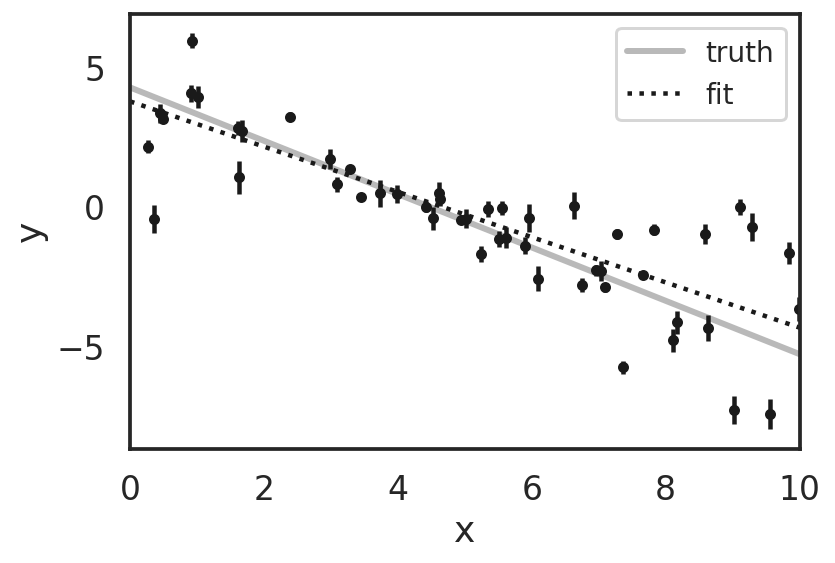

Hesse
m = -0.8139 +/- 0.0127 (m_true = -0.9594)
b = 3.792 +/- 0.068 (b_true = 4.294)
Minos
m = -0.8139 +/- (-0.0127, 0.0127) (m_true = -0.9594)
b = 3.792 +/- (-0.068, 0.068) (b_true = 4.294)


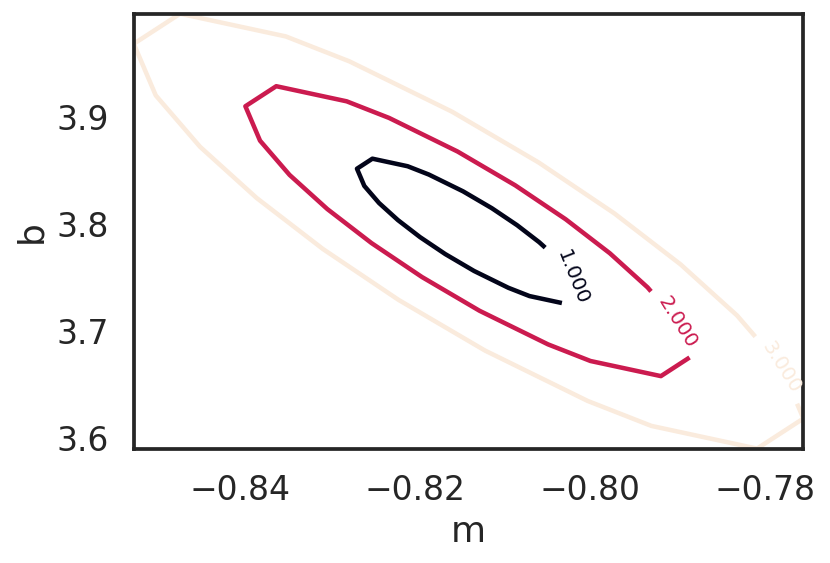

In [20]:
from iminuit import Minuit

def line(m, b, x, y):
    return m*x + b

def residual_function(m, b):
    #b, m = theta
    model = line(m, b, x, y)
    return np.sum(((model - y)/yerr)**2)

minu = Minuit(residual_function)

minu.migrad()  # run optimiser
minu.hesse()   # run covariance estimator
minu.minos()  # run minos estimator

m_pred, b_pred = minu.values.values()
m_std, b_std = minu.errors.values()
m_std_max, b_std_max, m_std_min, b_std_min = minu.merrors.values()

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":k", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print('Hesse')
print(f'm = {m_pred:.4f} +/- {m_std:.4f} (m_true = {m_true})')
print(f'b = {b_pred:.3f} +/- {b_std:.3f} (b_true = {b_true})')
print('Minos')
print(f'm = {m_pred:.4f} +/- ({m_std_min:.4f}, {m_std_max:.4f}) (m_true = {m_true})')
print(f'b = {b_pred:.3f} +/- ({b_std_min:.3f}, {b_std_max:.3f}) (b_true = {b_true})')

minu.draw_mncontour('m', 'b', nsigma=3)

___
___
# MCMC inference

There are a couple of packages for plotting the samples with these methods. One is `corner`, which is well known by most people I would say, and the other one, which I actually prefer and use here, is `chainconsumer`.

___
## emcee

In [21]:
def log_like(theta, x, y, yerr):
    m, b = theta
    model = m*x + b
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model)**2/sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, x, y, yerr)

pos = np.array([m_true, b_true]) + 1e-4*np.random.randn(32, 2)
nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(x, y, yerr), pool=pool)
    sampler.run_mcmc(pos, 4000, progress=True)

samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

100%|██████████| 4000/4000 [00:13<00:00, 288.01it/s]


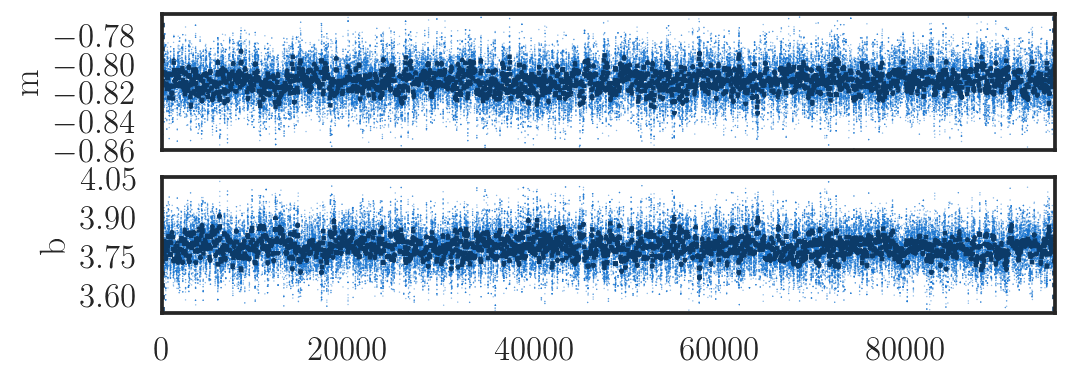

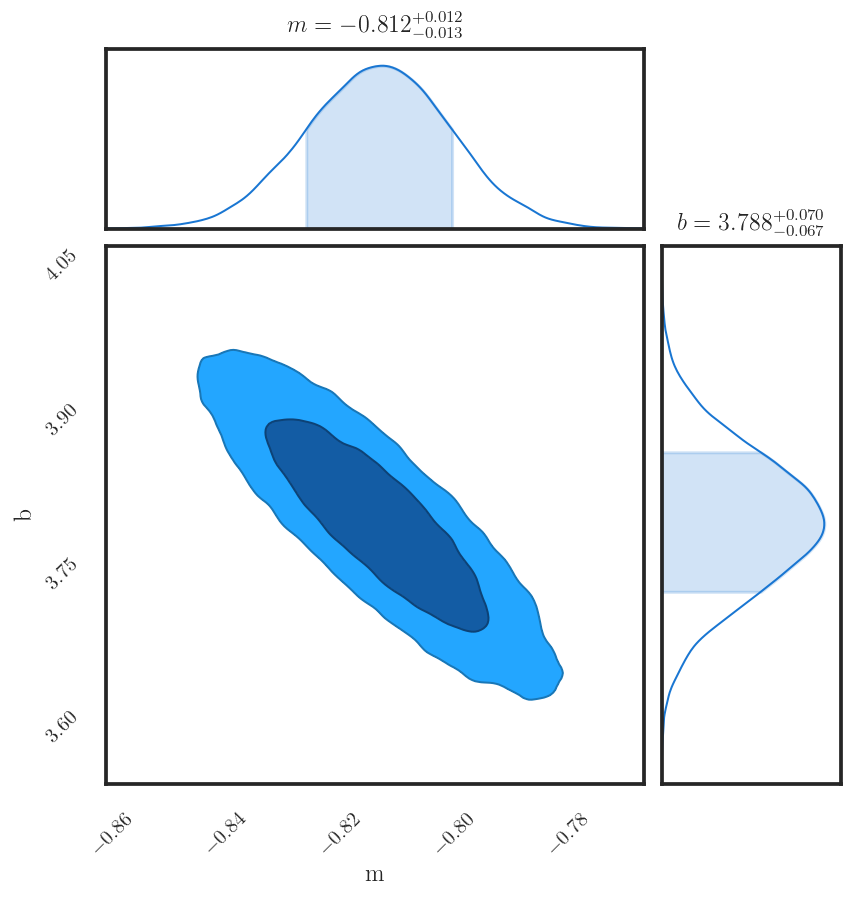

In [22]:
cc = ChainConsumer()
cc.add_chain(samples, parameters=['m', 'b'])

# plot chains
fig = cc.plotter.plot_walks(truth={"m": m_true, "b": b_true}, convolve=100)
plt.show()

# plot contours
fig = cc.plotter.plot(figsize=float(ndim), truth={"m": m_true, "b": b_true})
plt.show()

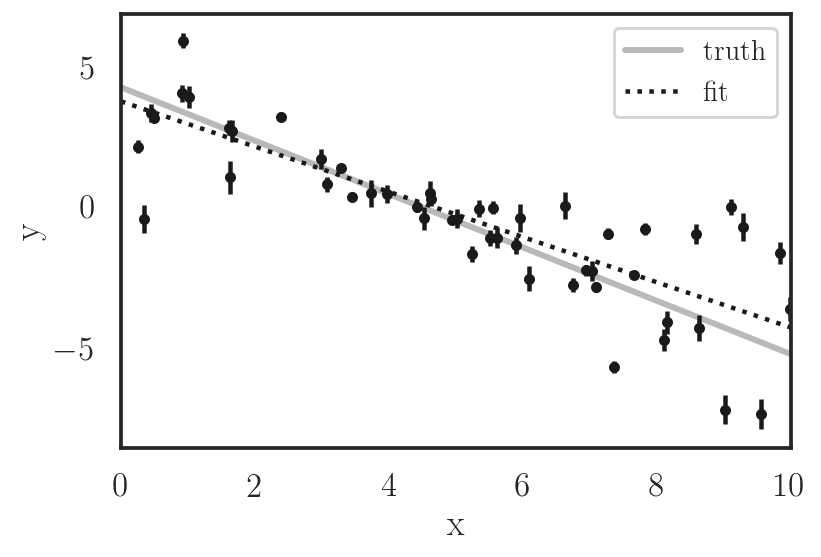

m = -0.8131 +/- (0.0127, 0.0124) (m_true = -0.9594)
b = 3.7896 +/- (0.0679, 0.0674) (b_true = 4.294)


In [23]:
m_mcmc = np.percentile(samples[:, 0], [16, 50, 84])
b_mcmc = np.percentile(samples[:, 1], [16, 50, 84])
m_pred, b_pred = m_mcmc[1], b_mcmc[1]
m_std_min, m_std_max = np.diff(m_mcmc)
b_std_min, b_std_max = np.diff(b_mcmc)

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":k", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f'm = {m_pred:.4f} +/- ({m_std_min:.4f}, {m_std_max:.4f}) (m_true = {m_true})')
print(f'b = {b_pred:.4f} +/- ({b_std_min:.4f}, {b_std_max:.4f}) (b_true = {b_true})')

## pystan

In [25]:
model = """
        data {
            int<lower=0> N;
            vector[N] x;
            vector[N] y;
        }
        parameters {
            real m;
            real b;
            real<lower=0> sigma;
        }
        model {
            y ~ normal(b + m*x, sigma);
        }
        """

data = {'N': len(x), 'x': x, 'y': y}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1defb22038d84b88c73c6495096e3e42 NOW.


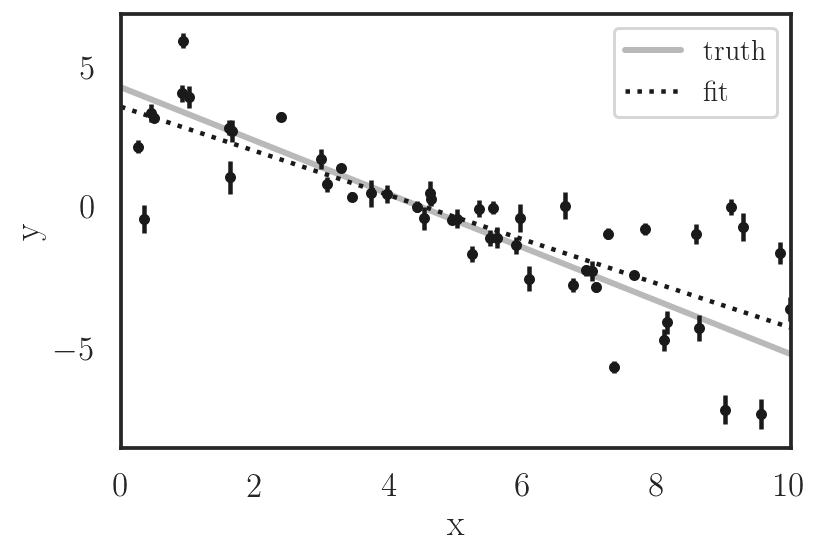

m = -0.7944 +/- 0.0828 (m_true = -0.9594)
b = 3.595 +/- 0.492 (b_true = 4.294)


In [26]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

m_pred, b_pred = df['mean']['m'], df['mean']['b']
m_std, b_std = df['sd']['m'], df['sd']['b']

# Extracting traces
m_trace = fit['m']
b_trace = fit['b']
sigma = fit['sigma']
lp = fit['lp__']

y_pred = m_pred*x0 + b_pred
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, y_pred, ":k", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f'm = {m_pred:.4f} +/- {m_std:.4f} (m_true = {m_true})')
print(f'b = {b_pred:.3f} +/- {b_std:.3f} (b_true = {b_true})')

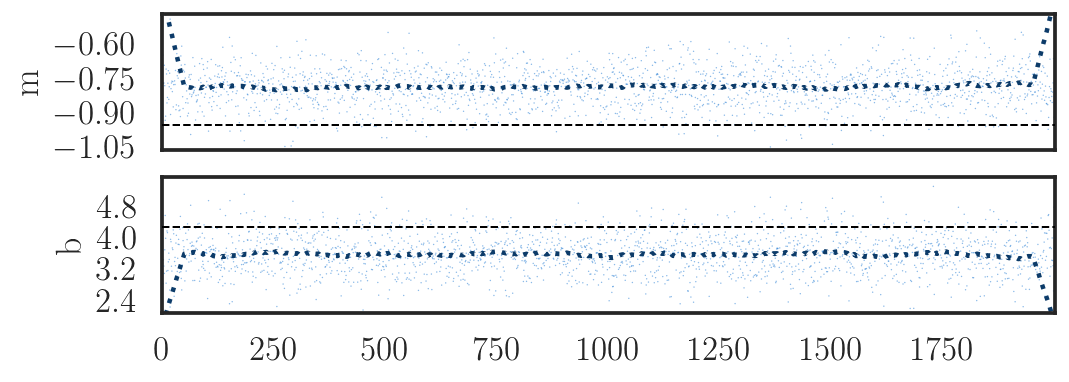

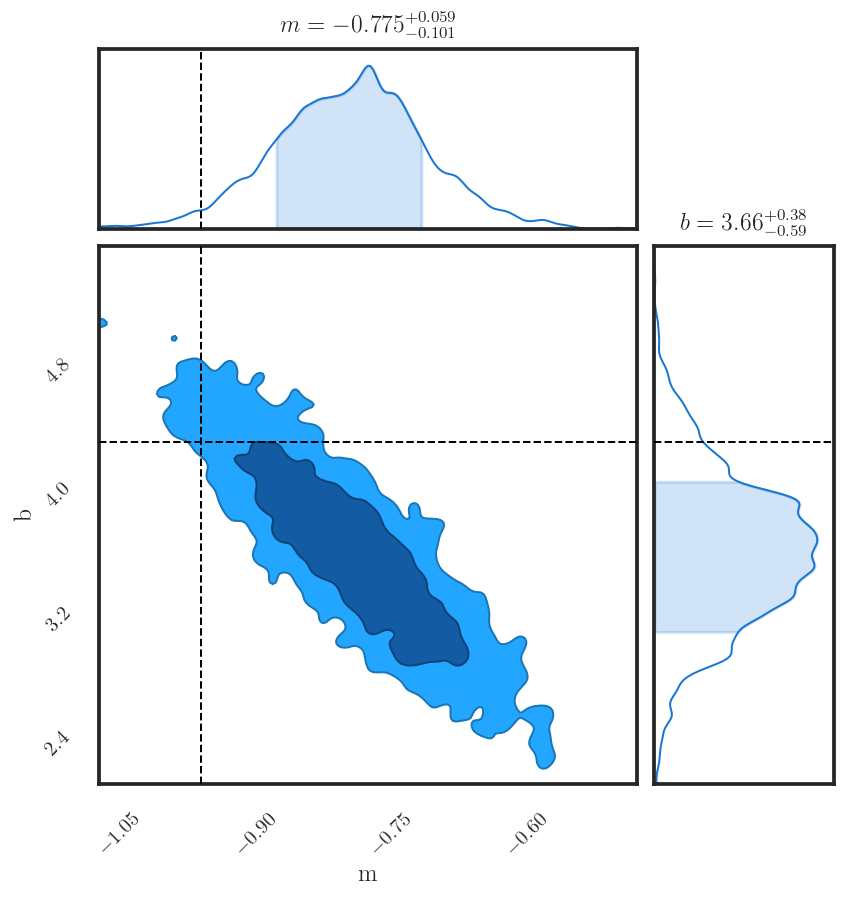

In [27]:
cc = ChainConsumer()
cc.add_chain(np.array([m_trace, b_trace]).T, parameters=['m', 'b'])

# plot chains
fig = cc.plotter.plot_walks(truth={"m": m_true, "b": b_true}, convolve=100)
plt.show()

# plot contours
fig = cc.plotter.plot(figsize=float(ndim), truth={"m": m_true, "b": b_true})
plt.show()

## pymc3

In [ ]:
basic_model = pymc3.Model()

with basic_model:
    
    p0 = np.array([m_true, b_true]) + 0.1 * np.random.randn(2)
    # Priors for unknown model parameters
    m = pymc3.Normal('m', mu=p0[0], sigma=2)
    b = pymc3.Normal('b', mu=p0[1], sigma=5)
    sigma = pymc3.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    model =m*x + b

    # Likelihood (sampling distribution) of observations
    Y_obs = pymc3.Normal('Y_obs', mu=model, sigma=sigma, observed=y)
    
map_estimate = pymc3.find_MAP(model=basic_model)

with basic_model:
   # instantiate sampler
    step = pymc3.Slice()

    # draw 5000 posterior samples
    trace = pymc3.sample(5000, step=step)

pymc3.traceplot(trace);
pymc3.summary(trace).round(2)

## Other packages

There are other packages for performing MCMC inference like: `Pyro/NumPyro`, `mici`, `TensorFlow Probability` and `Sampyl`.

___
___
# Neural Networks regression

The NN will fit the data without a given model. A proper fit would require training sets, testing sets and cross validation, but here only the most basic implementation is shown.

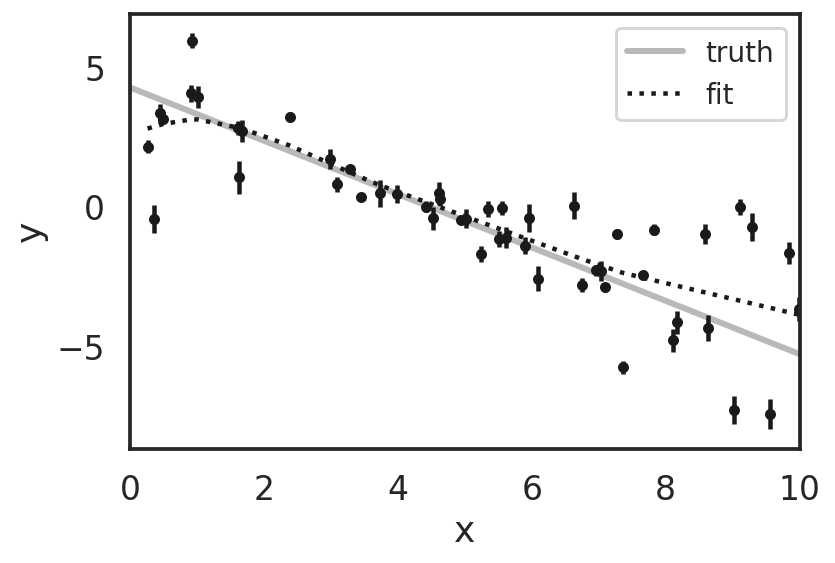

In [21]:
# NN model
model = Sequential()
model.add(Dense(32, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 1))

# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x[:, None], y, batch_size = 10, epochs = 100, verbose=0)

y_pred = model.predict(x[:, None])
y_true = m_true*x0 + b_true

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, y_true, "k", alpha=0.3, lw=3, label="truth")
#plt.plot(x0, y_pred, ":k", label="fit")
plt.plot(x[:, None], y_pred, ":k", label="fit")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()